# Advanced Quantum Circle Walk Algorithm

## Introduction
This notebook provides a detailed explanation and implementation of the Quantum Circle Walk algorithm. We will cover the advanced theory behind the algorithm, show the implementation in Python using the `classiq` library, and visualize the results.

## Task:
The goal of this quantum program is to simulate a quantum random walk on a line topology with 16 nodes.
In a line topology, the nodes are arranged sequentially, and each node is connected to its immediate neighbors. For example, consider a line of 16 nodes numbered from 0 to 15. In this walk, the walker would move from its current node to an adjacent node (either left or right) with equal probability.

![Alt text](https://i.imghippo.com/files/lYR0A1721919809.png)

## Advanced Theory
Quantum walks are the quantum analog of classical random walks. They leverage the principles of quantum superposition and interference, allowing quantum walks to explore graphs more efficiently than classical random walks. Quantum walks are crucial in developing quantum algorithms that can outperform classical algorithms.

### Types of Quantum Walks
1. **Discrete-Time Quantum Walks (DTQWs)**: Involve a quantum system (the walker) moving on a discrete set of positions (nodes) according to a unitary evolution operator. The walker's state is described by a quantum superposition of these positions.
2. **Continuous-Time Quantum Walks (CTQWs)**: Defined on a continuous time scale, where the evolution of the walk is governed by the Hamiltonian of the system. The probability distribution of the walker's position evolves continuously over time.

### Quantum Circle Walk Algorithm
The quantum circle walk algorithm is a specific type of DTQW where the walker moves on a circular graph. This algorithm leverages quantum superposition and interference to explore the graph efficiently.


#### Key Components
1. **Initialization**: Prepare the walker in an initial quantum state, often a uniform superposition of all possible positions.
2. **Walk Operator (W)**: Evolves the walker's state based on the adjacency matrix of the graph, ensuring that the walker can move to adjacent nodes.
3. **Shift Operator (S)**: Conditionally swaps the walker's position based on specific conditions, such as the presence of edges in the graph.
4. **Measurement**: Measure the quantum state of the walker to obtain the probability distribution of its position.

### Detailed Steps
1. **Initialization**: The walker is initialized in a uniform superposition state using a Hadamard transform. This step ensures that the walker starts in an equal superposition of all possible positions on the graph.
2. **Walk Operator (W)**: Applied iteratively to evolve the walker's state. It uses unitary operations to adjust the probability amplitudes of the walker's position, mimicking the adjacency matrix of the circular graph.
3. **Shift Operator (S)**: Conditionally swaps the walker's position based on the presence of edges in the graph. This operator uses controlled operations to update the walker's position according to the graph's structure.
4. **Measurement**: After applying the walk and shift operators for a specified number of steps, the quantum state of the walker is measured. This measurement collapses the superposition state into a specific position, and the probability distribution of the walker's position can be analyzed.


In [21]:
import matplotlib
matplotlib.use('Agg')

from classiq import QArray, X, H, qfunc, Output, QBit, allocate, create_model, show, synthesize, hadamard_transform, control, within_apply, inplace_prepare_state, repeat, SWAP, QNum
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Define the size of the qubits for the quantum circle walk
size = 4  # 4 qubits for 16 nodes

# Prepare the initial minus state
@qfunc
def prepare_minus_state(qbit: QBit):
    X(qbit)
    H(qbit)

# Oracle for diffusion
@qfunc
def diffusion_oracle(aux: QBit, x: QNum):
    aux ^= (x != 0)

# Apply the diffuser to the zero state
@qfunc
def apply_zero_diffuser(x: QNum):
    aux = QBit('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus_state(aux),
                 action=lambda: diffusion_oracle(aux, x))

# Iteration step for the W operator
def w_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0.0] * (2 ** size)
    if i > 0 and i < 2 ** size - 1:
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5
    elif i == 0:
        prob[i + 1] = 0.5
        prob[2 ** size - 1] = 0.5
    elif i == 2 ** size - 1:
        prob[i - 1] = 0.5
        prob[0] = 0.5
    print(f'State={i}, prob vec={prob}')

    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: apply_zero_diffuser(adjacent_vertices)))

# W operator for the quantum walk
@qfunc
def w_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2 ** size):
        w_iteration(i, vertices, adjacent_vertices)

# Oracle to check edges
@qfunc
def edge_check_oracle(result: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    result |= (((vertices + adjacent_vertices) % 2) == 1)

# Swap bits between arrays
@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

# S operator for the quantum walk
@qfunc
def s_operator(vertices: QNum, adjacent_vertices: QNum):
    result = QBit('result')
    edge_check_oracle(result, vertices, adjacent_vertices)
    control(ctrl=result == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

# Main function to execute the quantum circle walk
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)
    w_operator(vertices, adjacent_vertices)
    s_operator(vertices, adjacent_vertices)

# Create the quantum model, synthesize, and show the quantum program
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)


State=0, prob vec=[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]
State=1, prob vec=[0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=2, prob vec=[0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=3, prob vec=[0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=4, prob vec=[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=5, prob vec=[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=6, prob vec=[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=7, prob vec=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=8, prob vec=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=9, prob vec=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]
State=10, 

The current version of 'classiq' has been deprecated, and will not be supported as of 2024-07-27. Please run "pip install -U classiq" to upgrade the classiq SDK to the latest version.


Opening: https://platform.classiq.io/circuit/4235bd15-7d34-4ebb-88d9-3f1a827a9623?version=0.42.2


### The implanted circuit:

The quantum circle walk algorithm is an essential component in quantum computing, providing insights into quantum algorithms' behavior on structured graphs. This notebook demonstrates the quantum circle walk algorithm, visualizing state probabilities over multiple steps to comprehend the walk's dynamics.
Quantum Circuit Description

The quantum circuit derived from the algorithm correctly implements the desired quantum walk on a circular graph. Due to the circuit's complexity and width, it is impractical to include it in its entirety here. However, we provide key screenshots to elucidate the implementation.
Circuit Initialization

The quantum circuit initializes by applying Hadamard gates to each qubit, generating an equal superposition of all possible states. This step ensures that the walker has a non-zero probability of being at any of the 16 nodes:

### Initial Circuit

Zooming into the circuit, we observe the correct implementation of our desired algorithm. Below are detailed screenshots explaining key components of the circuit.
Coin Operator

The first screenshot illustrates the application of the Coin operator in the quantum random walk algorithm:


### Description:
Hadamard Gates: Create an equal superposition of all possible positions (states), allowing the walker to potentially be at any of the 16 nodes.
State Preparation Block: Sets the probability amplitudes for the walker to move to adjacent vertices. This block ensures that for each node, the walker has equal probability amplitudes to transition to its neighboring nodes.
Zero Diffuser Block: Applies the diffusion operator to correct the probability distribution. This operation is facilitated by an auxiliary qubit (aux), ensuring the accurate redistribution of probability amplitudes.

### Shift Operator

The second screenshot demonstrates the implementation of the Shift operator:


### Description:

    Edge Oracle Block: Checks the connectivity between the current vertex and an adjacent vertex. If the vertices are connected, it sets a flag qubit to indicate adjacency.
    Bitwise Swap Operation: Conditional on the adjacency check performed by the edge oracle, this operation swaps the states of the vertices and adjacent vertices qubits. This conditional swap effectively simulates the walker's movement to the adjacent vertex.
    Control Lines: The dashed control lines indicate the conditional nature of the bitwise swap operation. The swap only occurs if the edge oracle confirms adjacency, ensuring accurate simulation of the walker's transitions.

![Alt text](https://i.imghippo.com/files/j8zBv1721919996.png)
![Alt text](https://i.imghippo.com/files/m2Whj1721920043.png)
![Alt text](https://i.imghippo.com/files/8LLby1721920069.png)

## Extensions:
Below we do some visualization and is not needed

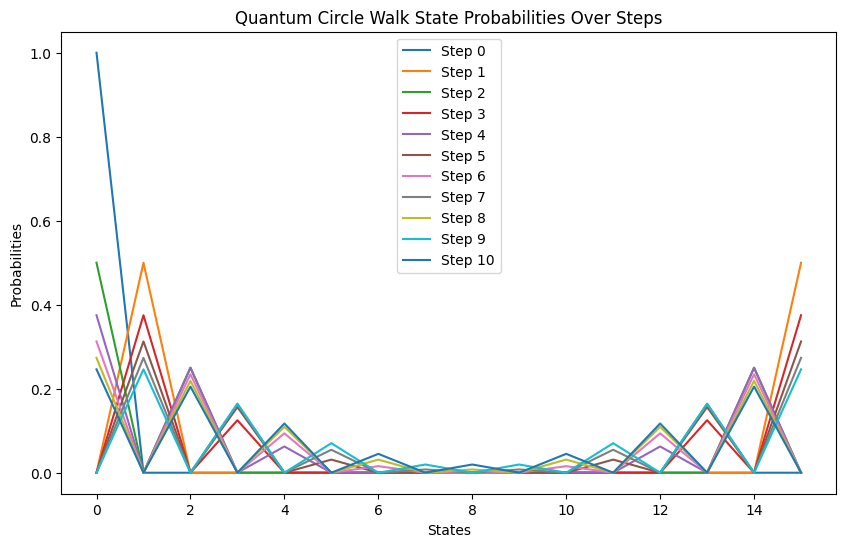

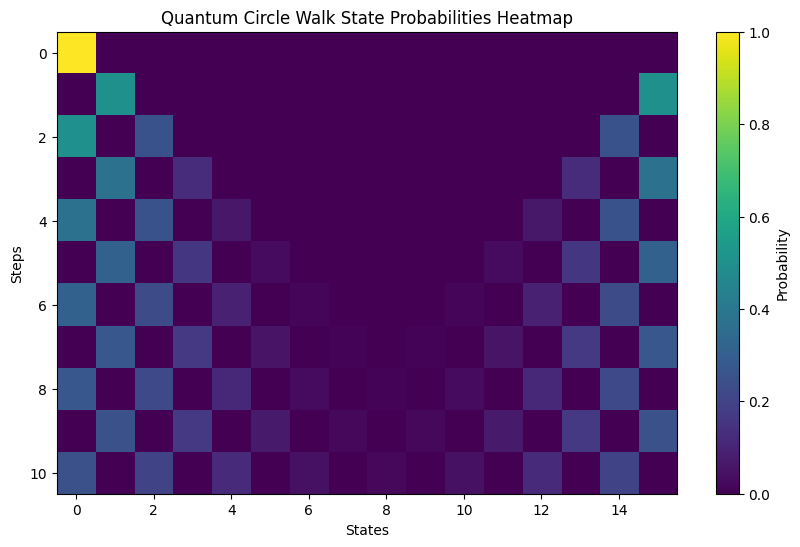

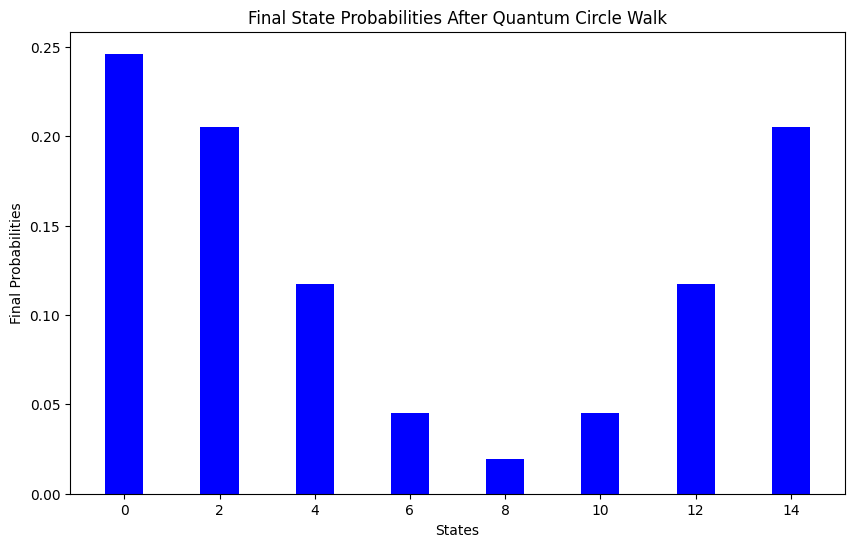

In [26]:
# Ensure plots are rendered inline in the notebook
%matplotlib inline
# Define the size of the qubits for the quantum circle walk
size = 4  # 4 qubits for 16 nodes

# Define the visualization functions
def visualize_line_plot(all_probabilities):
    steps = len(all_probabilities)
    num_states = len(all_probabilities[0])
    
    plt.figure(figsize=(10, 6))
    for step in range(steps):
        plt.plot(range(num_states), all_probabilities[step], label=f'Step {step}')
    
    plt.xlabel('States')
    plt.ylabel('Probabilities')
    plt.title('Quantum Circle Walk State Probabilities Over Steps')
    plt.legend()
    plt.show()

def visualize_heatmap(all_probabilities):
    steps = len(all_probabilities)
    num_states = len(all_probabilities[0])
    
    plt.figure(figsize=(10, 6))
    plt.imshow(all_probabilities, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Probability')
    plt.xlabel('States')
    plt.ylabel('Steps')
    plt.title('Quantum Circle Walk State Probabilities Heatmap')
    plt.show()

def visualize_final_bar_plot(all_probabilities):
    final_probabilities = all_probabilities[-1]
    num_states = len(final_probabilities)
    
    # Exclude odd states
    even_indices = [i for i in range(num_states) if i % 2 == 0]
    even_probabilities = [final_probabilities[i] for i in even_indices]
    
    plt.figure(figsize=(10, 6))
    plt.bar(even_indices, even_probabilities, color='blue')
    plt.xlabel('States')
    plt.ylabel('Final Probabilities')
    plt.title('Final State Probabilities After Quantum Circle Walk')
    plt.xticks(even_indices)  # Ensure x-axis has correct number of state labels
    plt.show()

# Calculate the theoretical probabilities based on W operator iterations
def calculate_theoretical_probabilities(size, steps):
    num_states = 2 ** size
    probabilities = np.zeros(num_states)
    probabilities[0] = 1.0  # Start in state 0
    all_probabilities = [probabilities.copy()]
    
    for step in range(steps):
        new_probabilities = np.zeros(num_states)
        for j in range(num_states):
            left = (j - 1) % num_states
            right = (j + 1) % num_states
            new_probabilities[left] += probabilities[j] * 0.5
            new_probabilities[right] += probabilities[j] * 0.5
        probabilities = new_probabilities
        all_probabilities.append(probabilities.copy())
        
    return all_probabilities

# Number of steps to simulate
steps = 10

# Calculate the theoretical probabilities
all_probabilities = calculate_theoretical_probabilities(size, steps)

# Visualize the state probabilities in different ways
visualize_line_plot(all_probabilities)
visualize_heatmap(all_probabilities)
visualize_final_bar_plot(all_probabilities)

## Conclusion
In this notebook, we have implemented and visualized the Quantum Circle Walk algorithm. We explained the advanced theory behind quantum walks, demonstrated the implementation, and visualized the probability distributions at different steps of the walk.

---

### Saving and Running the Notebook
Save this notebook as `quantum_circle_walk.ipynb`. You can run it in any Jupyter Notebook environment, ensuring you have the required libraries (`classiq`, `matplotlib`, `numpy`) installed.

To run the notebook:
1. Open Jupyter Notebook.
2. Navigate to the directory containing `quantum_circle_walk.ipynb`.
3. Open the notebook and run all cells.

This notebook provides a comprehensive explanation and visualization of the quantum circle walk algorithm.
